In [113]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg


## Homework 3: Due 2017-11-03

Write a solver for the regularized $p$-Laplacian, $$ -\nabla\cdot\big( \kappa(\nabla u) \nabla u \big) = 0 $$ where $$ \kappa(\nabla u) = \big(\frac{1}{2} \epsilon^2 + \frac{1}{2} \nabla u \cdot \nabla u \big)^{\frac{p-2}{2}}, $$ $ \epsilon > 0$, and $1 < p < \infty$. The case $p=2$ is the conventional Laplacian. This problem gets more strongly nonlinear when $p$ is far from 2 and when $\epsilon$ approaches zero. The $p \to 1$ limit is related to plasticity and has applications in non-Newtonion flows and structural mechanics.

Implement a "Picard" solver, which is like a Newton solver except that the Jacobian is replaced by the linear system $$ J_{\text{Picard}}(u) \delta u \sim -\nabla\cdot\big( \kappa(\nabla u) \nabla \delta u \big) . $$ This is much easier to implement than the full Newton linearization. How fast does this method converge for values of $p < 2$ and $p > 2$?

Use the linearization above as a preconditioner to a Newton-Krylov method. That is, use scipy.sparse.linalg.LinearOperator to apply the Jacobian to a vector $$ \tilde J(u) v = \frac{F(u + h v) - F(u)}{h} . $$ Then for each linear solve, use scipy.sparse.linalg.gmres and pass as a preconditioner, a direct solve with the Picard linearization above. (You might find scipy.sparse.linalg.factorized to be useful. Compare algebraic convergence to that of the Picard method.

Can you directly implement a Newton linearization? Either do it or explain what is involved. How will its nonlinear convergence compare to that of the Newton-Krylov method?


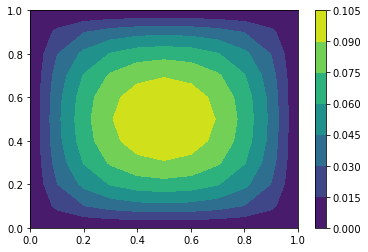

In [288]:
def kappa(x, y):
    #return 1 - 2*(x-.5)**2 - 2*(y-.5)**2
    return 1e-2 + 2*(x-.5)**2 + 2*(y-.5)**2
def grad_kappa(x, y):
    #return -4*(x-.5), -4*(y-.5)
    return 4*(x-.5), 4*(y-.5)
def hgrid(h):
    m = int(1/h + 1)  # Number of elements in terms of nominal grid spacing h
    h = 1 / (m-1)     # Actual grid spacing
    c = np.linspace(0, 1, m)
    y, x = np.meshgrid(c, c)
    return x, y

def nonlinear2d_div(h, x, y,eps, p, u, forcing, g0, dirichlet=((),())):
    m = x.shape[0]
    u0 = g0(x, y).flatten()
    F = -forcing(x, y).flatten()
    ai = []
    aj = []
    av = []
    def idx(i, j):
        i = (m-1) - abs(m-1 - abs(i))
        j = (m-1) - abs(m-1 - abs(j))
        return i*m + j
    mask = np.ones_like(x, dtype=bool)
    mask[dirichlet[0],:] = False
    mask[:,dirichlet[1]] = False
    mask = mask.flatten()
    u = u.flatten()
    F[mask == False] = u[mask == False] - u0[mask == False]
    u[mask == False] = u0[mask == False]
    for i in range(m):
        for j in range(m):
            row = idx(i, j)
            stencili = np.array([idx(*pair) for pair in [(i-1, j), (i, j-1), (i, j), (i, j+1), (i+1, j)]])
            # Stencil to evaluate gradient at four staggered points
            grad = np.array([[-1, 0, 1, 0, 0],
                                [0, -1, 1, 0, 0],
                                [0, 0, -1, 1, 0],
                                [0, 0, -1, 0, 1]]) / h
            # Stencil to average at four staggered points
            avg  = np.array([[1, 0, 1, 0, 0],
                                [0, 1, 1, 0, 0],
                                [0, 0, 1, 1, 0],
                                [0, 0, 1, 0, 1]]) / 2
            # Stencil to compute divergence at cell centers from fluxes at four staggered points
            div = np.array([-1, -1, 1, 1]) / h
            ustencil = u[stencili]
            ustag = avg @ ustencil
            #print(np.shape(grad@ustencil))
            #print(np.shape(ustag))
            #print(grad@ustencil)
            #print(np.transpose((grad@ustencil)))
            kappa = (0.5*eps**2 + 0.5*(grad@ustencil)*(grad@ustencil))**((p-2)/2.)
            if mask[row] == 0: # Dirichlet boundary
                ai.append(row)
                aj.append(row)
                av.append(1)
            else:
                F[row] -= div @ (kappa[:,None] * grad @ ustencil)
                Jpicard = -div @ (kappa[:, None]*grad)
                #Jstencil = -div @ (kappa[:,None] * grad
                 #   + 2*(ustag*(grad @ ustencil))[:,None] * avg)
                smask = mask[stencili]
                ai += [row]*sum(smask)
                aj += stencili[smask].tolist()
                av += Jpicard[smask].tolist()
                #av += Jstencil[smask].tolist()
    J = sp.csc_matrix((av, (ai, aj)), shape=(m*m,m*m))
    return F, J

h = .1
x, y = hgrid(h)
eps = 1
p = 3
u = 0*x
F, J = nonlinear2d_div(h, x, y, eps, p, u, lambda x,y: 0*x+1,
                       lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)))
deltau = sp.linalg.spsolve(J, -F).reshape(x.shape)
plt.contourf(x, y, deltau)
plt.colorbar();
plt.show()

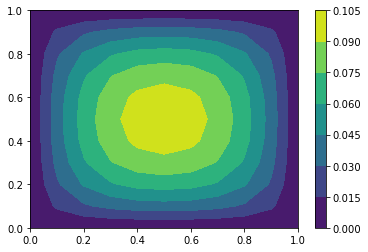

In [289]:
def solve_nonlinear(h, eps, p, g0, dirichlet, atol=1e-8, verbose=False):
    x, y = hgrid(h)
    u = 0*x
    for i in range(200):
        F, J = nonlinear2d_div(h, x, y, eps,p,u, lambda x,y: 0*x+1, lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)))
        anorm = np.linalg.norm(F, np.inf)
        if verbose:
            print('{:2d}: anorm {:8e}'.format(i,anorm))
        if anorm < atol:
            break
        deltau = sp.linalg.spsolve(J, -F)
        u += deltau.reshape(x.shape)
    return x, y, u, i


x, y, u, i = solve_nonlinear(.1, eps, p, lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)), verbose=False)
plt.contourf(x, y, u)
plt.colorbar();
plt.show()

## As $\epsilon \rightarrow 0$:
We see that as $\epsilon \rightarrow 0$, this system becomes more nonlinear and our method takes longer to converge to a solution within our defined tolerance threshold. In fact, for small enough $\epsilon$ we see that it takes more than 200 iterations to converge.

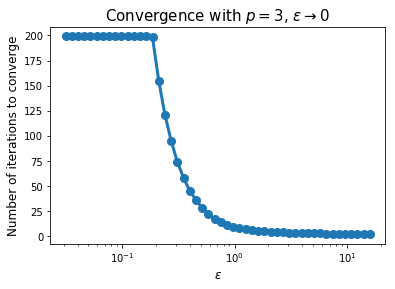

In [164]:
p = 3
epsi = np.logspace(-5,4, base=2)
ita=np.zeros_like(epsi)
count = 0
for ep in epsi:
    eps=ep
    x, y, u, i = solve_nonlinear(.1,eps, p, lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)), verbose=False)
    ita[count]=i
    count+=1
plt.semilogx(epsi, ita, marker="o", ms='8', lw='3')
plt.xlabel(r'$\epsilon$',fontsize='12')
plt.ylabel('Number of iterations to converge',fontsize='12')
plt.title(r'Convergence with $p=3$, $\epsilon \rightarrow 0$',fontsize='15')
plt.show()

## For $p>2$:
Similarly,this system becomes more nonlinear for values of $p$ greater than 2 and the method converges in more and more iterations as $p$ gets further from 2. For values of $p>5$, the method converges in more than 200 iterations.

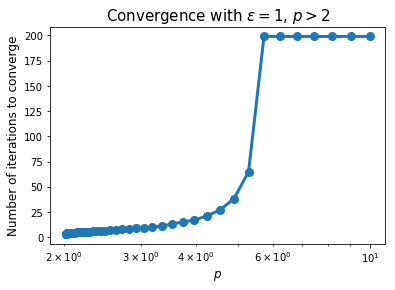

In [165]:
eps = 1
pp = 2+np.logspace(-6,3, base=2)
ita=np.zeros_like(pp)
count = 0
for p in pp:
    x, y, u, i = solve_nonlinear(.1,eps, p, lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)), verbose=False)
    ita[count]=i
    count+=1
plt.semilogx(pp, ita, marker="o", ms='8', lw='3')
plt.xlabel(r'$p$',fontsize='12')
plt.ylabel('Number of iterations to converge',fontsize='12')
plt.title(r'Convergence with $\epsilon=1$, $p > 2$',fontsize='15')
plt.show()

## For $p<2$:
For $\eps=1$ and $p<2$ the method consistently converges to a solution in 6 or less iterations. The final point we see in the plot below corresponds to when $p=2$.

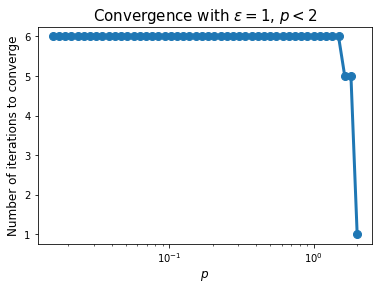

In [166]:
eps = 1
pp = np.logspace(-6,1, base=2)
ita=np.zeros_like(pp)
count = 0
for p in pp:
    x, y, u, i = solve_nonlinear(.1,eps, p, lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)), verbose=False)
    ita[count]=i
    count+=1
plt.semilogx(pp, ita, marker="o", ms='8', lw='3')
plt.xlabel(r'$p$',fontsize='12')
plt.ylabel('Number of iterations to converge',fontsize='12')
plt.title(r'Convergence with $\epsilon=1$, $p < 2$',fontsize='15')
plt.show()

## Adding a preconditioner to the Newton Krylov method
Below we reproduce the fsolve_newtonkrylov( ) method from class, and add the computed $J_{picard}$ matrix as a preconditioner to the gmres function. We also use the computed associated $F$ as our residual function. As seen below, this preconditioning allows for a faster convergence.

In [307]:
import scipy.sparse.linalg as splinalg

def fsolve_newtonkrylov(u0, epsilon=1e-8, rtol=1e-10, maxit=50, verbose=False):
    """ from @jedbrown's AlgebraicSolvers notebook
    """
    x,y=hgrid(.1)
    eps=0.05
    p=3
    u = u0.copy()
    u=u.flatten()
    F1, J1 = nonlinear2d_div(.1, x, y, eps, p, u, lambda x,y: 0*x+1, lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)))
    norm0 = np.linalg.norm(F1)
    for i in range(maxit):
        #compute picard jacobian for given u
        Fp, Jp = nonlinear2d_div(.1, x, y, eps, p, u, lambda x,y: 0*x+1, lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)))
        #factorize picard Jacobian to get a fuction to apply as preconditioner
        solve = splinalg.factorized(Jp)
        def Jpic_fd(v):
            FpicV,_=nonlinear2d_div(.1, x, y, eps, p, (u+epsilon*v), lambda x,y: 0*x+1, lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)))
            return (FpicV - Fp) / epsilon
        Ju = splinalg.LinearOperator((np.shape(u)[0],np.shape(u)[0]), matvec=Jpic_fd)
        #turn the solve() function from above into a linear operator
        Pre = splinalg.LinearOperator(np.shape(Jp), matvec=solve) 
        #add the preconditioner to the gmres command
        du, info = splinalg.gmres(Ju, Fp, M=Pre)
        if info != 0:
            raise RuntimeError('GMRES failed to converge: {:d}'.format(info))
        u -= du
        Fp, Jp =nonlinear2d_div(.1, x, y, eps, p, u, lambda x,y: 0*x+1, lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)))
        norm = np.linalg.norm(Fp)
        if verbose:
            print('Newton {:d} anorm {:6.2e} rnorm {:6.2e}'.format(i, norm, norm/norm0))
        if norm < rtol * norm0:
            break
    return u, i

fsolve_newtonkrylov( 0*u, rtol=1e-6, verbose=True)

Newton 0 anorm 1.32e+03 rnorm 1.46e+02
Newton 1 anorm 3.27e+02 rnorm 3.64e+01
Newton 2 anorm 7.98e+01 rnorm 8.86e+00
Newton 3 anorm 1.81e+01 rnorm 2.01e+00
Newton 4 anorm 3.07e+00 rnorm 3.41e-01
Newton 5 anorm 1.97e-01 rnorm 2.19e-02
Newton 6 anorm 9.50e-04 rnorm 1.06e-04
Newton 7 anorm 1.43e-07 rnorm 1.59e-08


(array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.03200343,  0.04981562,  0.06068845,
         0.06756058,  0.07084463,  0.06756058,  0.06068845,  0.04981562,
         0.03200343,  0.        ,  0.        ,  0.04981562,  0.08540816,
         0.10906822,  0.12403167,  0.13121055,  0.12403167,  0.10906822,
         0.08540816,  0.04981562,  0.        ,  0.        ,  0.06068845,
         0.10906822,  0.14459995,  0.16816844,  0.17974353,  0.16816844,
         0.14459995,  0.10906822,  0.06068845,  0.        ,  0.        ,
         0.06756058,  0.12403167,  0.16816844,  0.19908398,  0.21485997,
         0.19908398,  0.16816844,  0.12403167,  0.06756058,  0.        ,
         0.        ,  0.07084463,  0.13121055,  0.17974353,  0.21485997,
         0.23333358,  0.21485997,  0.17974353,  0.13121055,  0.07084463,
         0.        ,  0.        ,  0.06756058,  0.1

## Full  Newton linearization
In order to implement a full Newton linearization, I would need to compute the second term in the full Jacobian, 
$$J=-\nabla \cdot (\kappa(\nabla u)\nabla \delta u + \frac{\partial \kappa}{\partial u}\delta u \nabla u)$$
which would require finding $\frac{\partial \kappa}{\partial u}$. Using this full newton linearization would have quadratic convergence, whereas the Newton-Krylov method converges linearly. 